# Calculate ciCOH Values: 

* For both normal and mild LFP data 

* Reach phase [reachonset touch] in single kluverboard task

* [9 11]Hz

## Import Packages

In [1]:
import os, sys
import scipy.io as sio
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import random
import pandas as pd
%matplotlib inline

In [2]:
# extract the exp folder path
currfolder = os.getcwd()
codefolder = currfolder[0 : currfolder.find('code')+len('code')]

# add path the exp folder
sys.path.append(codefolder)

# import_nbmodule used for import package in .ipynb
import import_nbmodule

# import util/folder_extract.pynb 
from util.folder_extract import exp_subfolders, code_corresfolder

# import ciCoherence_overtime in connAnalyTool/synchronization_indices.ipynb
from connAnalyTool.synchronization_indices import ciCoherence_acrosstrials
from connAnalyTool.synchronization_indices import ciCoherence_overtime

importing Jupyter notebook from /Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/util/folder_extract.ipynb
importing Jupyter notebook from /Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/connAnalyTool/synchronization_indices.ipynb


## exp subfolders & code_corresfolder

In [3]:
_, _, pipelinefolder, _= exp_subfolders()

In [4]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [5]:
nb_name = nb_name[0: nb_name.find('.ipynb')]

# corresfolder
corresfolder, correparentfolder = code_corresfolder(os.getcwd(), nb_name)

## global parameters

In [6]:
freq = [17, 19]

eventphase = 'return'

animal = 'Pinky'

tdur_min, tdur_max = 0.5, 1
tdur_reach = tdur_min

In [7]:
leadSTN_chns, leadGP_chns = [5,6], [6, 7] # start from 0

In [8]:
coli_target, coli_reachonset, coli_touch, coli_returnonset, coli_mouth = 0, 1, 2, 3, 4


if eventphase == 'reach':
    cols = [coli_reachonset, coli_touch]
    
elif eventphase == 'return':
    cols = [coli_returnonset, coli_mouth]

## input setup

In [9]:
inputfolder = os.path.join(pipelinefolder, 'NHP_Pinky/0_dataPrep/SKT/m3_STKData_narrowfiltered17_19')

In [10]:
chnInf_folder = correparentfolder
chnInf_file = os.path.join(chnInf_folder, 'chn_brainArea_simCoord_M1ThaSMADBS.csv')

## save file setup

In [11]:
savefolder = corresfolder
savefilename =  'ciCOH_STK_' + eventphase + '_' + 'freq_' + str(freq[0]) + '_' + str(freq[1])  +'.pickle'
savefile_ciCOH = os.path.join(savefolder, savefilename)

## extract lfp 
from all the files in mild or normal condition

### extract lfpnormal_alltrials, lfpmild_alltrials

In [12]:
## glob all .mat files (both mild and normal files)
files = glob.glob(os.path.join(inputfolder, '*.mat'))


### combine the trials from all the files that last longer than tdur_min and less than tdur_max ###
if 'lfpmild_alltrials' in locals():
    del lfpmild_alltrials
if 'lfpnormal_alltrials'in locals():
    del lfpnormal_alltrials
    
for filei, file in enumerate(files):
    
    # load the stk trial data in alpha band with idxevent, idxevent_varNames, fs
    matdat = sio.loadmat(file, 
                         variable_names = ['lfpdata', 
                                           'idxevent_Matrix' ,'fs'], 
                         struct_as_record = False, squeeze_me = True)
    # fs: sample rate
    fs = matdat['fs'] 
    # idxevent (np.ndarray, ntrials * 5) indices for targetonset, reachonset, reach, return and mouth
    idxevent = matdat['idxevent_Matrix']
        
    # lfp
    lfp = matdat['lfpdata']
             
    idxdur_min, idxdur_max = int(np.round(tdur_min * fs)), int(np.round(tdur_max * fs))
    idxdur_reach = int(np.round(tdur_reach * fs))
    
    if len(lfp.shape) == 2: # only has one trial
        lfp = np.expand_dims(lfp, axis = 2)
        idxevent = np.expand_dims(idxevent, axis = 0)
    
    ntrials = lfp.shape[2]
    
    # deal each trial in lfp of one file
    for triali in range(ntrials):
        
        # start and end indices over time of specific phase for triali 
        idxtime_str, idxtime_end = int(idxevent[triali][cols[0]]), int(idxevent[triali][cols[1]])    
        
        # remove trials of reach phase longer than tdur_max and shorter than tdur_min
        if idxtime_end - idxtime_str < idxdur_min or idxtime_end - idxtime_str > idxdur_max:
            continue;
            
            
        # extract lfp data in specific phase of one trial (n_chns * n_times)
        lfp_1trial = np.expand_dims(lfp[:, idxtime_str:idxtime_str + idxdur_reach, triali], axis=2)       
        
        # mild case
        if 'mild' in file and 'normal' not in file:
            
            # append new trial to lfpmild_alltrials
            if 'lfpmild_alltrials' not in locals():
                lfpmild_alltrials = lfp_1trial
            else:
                lfpmild_alltrials = np.concatenate((lfpmild_alltrials, lfp_1trial), axis = 2)
                
        # normal case
        if 'normal' in file and 'mild' not in file:
            
            # append new trial to lfpnormal_alltrials
            if 'lfpnormal_alltrials' not in locals():
                lfpnormal_alltrials = lfp_1trial
            else:
                lfpnormal_alltrials = np.concatenate((lfpnormal_alltrials, lfp_1trial), axis = 2)
                
        del lfp_1trial, idxtime_str, idxtime_end
    
    del matdat, fs, idxevent, lfp

### balance mild and normal trials number

In [13]:
if lfpmild_alltrials.shape[2] < lfpnormal_alltrials.shape[2]:
    ntrials_ba = lfpmild_alltrials.shape[2]
else:
    ntrials_ba = lfpnormal_alltrials.shape[2]

idx_batrials_normal = random.sample(range(0, lfpnormal_alltrials.shape[2]), ntrials_ba) 
idx_batrials_mild = random.sample(range(0, lfpmild_alltrials.shape[2]), ntrials_ba) 


# balance trials
phaselfp_normal_ba = lfpnormal_alltrials[:,:,idx_batrials_normal]
phaselfp_mild_ba = lfpmild_alltrials[:,:,idx_batrials_mild]

In [14]:
print(phaselfp_normal_ba.shape)
print(phaselfp_mild_ba.shape)

(144, 250, 50)
(144, 250, 50)


### biploar dbs 

In [15]:
# STN channel numbers
ch1_STN, ch2_STN = leadSTN_chns[0] + 128, leadSTN_chns[1] + 128

# get the bipolar lfp by substrating 
lfpSTN_normal = np.expand_dims(phaselfp_normal_ba[ch1_STN, :, :] - phaselfp_normal_ba[ch2_STN, :, :], axis = 0)
lfpSTN_mild = np.expand_dims(phaselfp_mild_ba[ch1_STN, :, :] - phaselfp_mild_ba[ch2_STN, :, :], axis = 0)

In [16]:
# GP channel numbers
ch1_GP, ch2_GP = leadGP_chns[0] + 128, leadGP_chns[1] + 128

# get the bipolar lfp by substrating 
lfpGP_normal = np.expand_dims(phaselfp_normal_ba[ch1_GP, :, :] - phaselfp_normal_ba[ch2_GP, :, :], axis = 0)
lfpGP_mild = np.expand_dims(phaselfp_mild_ba[ch1_GP, :, :] - phaselfp_mild_ba[ch2_GP, :, :], axis = 0)

### channel information

In [17]:
### load channel information ###
df = pd.read_csv(chnInf_file, header = 0)


###  channel matchni and recording chni  ###
chnInf_matchni, chnInf_recchni = df['mat_chni'], df['recording_chni']

chnInf_brainarea = df['brainarea']

x, y = df['simulated_x'].to_numpy(), df['simulated_y'].to_numpy()
chnInf_coord = np.concatenate((np.expand_dims(x, axis = 1), np.expand_dims(y, axis = 1)), axis = 1)



### Remove nonused channels ###

# extract the indices in which the corresponding channels are not used
idx_mask = ~chnInf_brainarea.isnull()
idx_notused = [i for i, isnan in enumerate(idx_mask) if isnan == False]


chnInf_recchni = chnInf_recchni[idx_mask].to_numpy()
chnInf_matchni = chnInf_matchni[idx_mask].to_numpy()
chnInf_brainarea = chnInf_brainarea[idx_mask].tolist()
chnInf_coord = chnInf_coord[idx_mask]

### remove the data of the noused channels

In [18]:
if phaselfp_normal_ba.shape[0] == phaselfp_mild_ba.shape[0]:
    nchns = phaselfp_normal_ba.shape[0]


# # extract the idx whose channels are not used
matchni_notused = np.arange(0, nchns, 1).tolist()

for idx, matchni in enumerate(chnInf_matchni):
    if 'STN' in chnInf_brainarea[idx] or 'GP' in chnInf_brainarea[idx]:
        continue
        
    matchni_notused.remove(matchni)

In [19]:
print(phaselfp_mild_ba.shape)

# remove the data of the channel not used
phaselfp_normal_ba = np.delete(phaselfp_normal_ba, matchni_notused, axis = 0)

# remove the data of the channel not used
phaselfp_mild_ba = np.delete(phaselfp_mild_ba, matchni_notused, axis = 0)

print(phaselfp_mild_ba.shape)

# add bipolar STN and GP lfp data
phaselfp_normal_ba = np.concatenate((phaselfp_normal_ba, lfpSTN_normal, lfpGP_normal), axis = 0)
phaselfp_mild_ba = np.concatenate((phaselfp_mild_ba, lfpSTN_mild, lfpGP_mild), axis = 0)

print(phaselfp_mild_ba.shape)

(144, 250, 50)
(123, 250, 50)
(125, 250, 50)


## calculate ciCOH across trials

#### ciCOH normal

In [20]:
lfp_alltrials = lfpnormal_alltrials


### calculate ciCOH between each pair of channels ###

nchns = lfp_alltrials.shape[0]
# initial ciCOH_alltrials array for all trials
ciCOH_alltrials = np.zeros((nchns, nchns))
for chni in range(nchns-1):

    # signal of channel chni
    signal1 = lfp_alltrials[chni, :, :]

    for chnj in range(chni+1, nchns):

        # signal of channel chnij
        signal2 = lfp_alltrials[chnj, :, :]

        # ciCOH_alltrials assignment
        ciCOH_alltrials[chni, chnj] =  np.mean(ciCoherence_acrosstrials(signal1, signal2))

        # symmetrical
        ciCOH_alltrials[chnj, chni] = ciCOH_alltrials[chni, chnj]

        del signal2
    del signal1

ciCOH_normal = ciCOH_alltrials
del ciCOH_alltrials, nchns

/Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/connAnalyTool/synchronization_indices.ipynb:41: RuntimeWarning: invalid value encountered in true_divide
  "### 1. ciCoherence_acrosstrials\n",
/Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/connAnalyTool/synchronization_indices.ipynb:42: RuntimeWarning: invalid value encountered in sqrt
  "\n",
/Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/connAnalyTool/synchronization_indices.ipynb:42: RuntimeWarning: divide by zero encountered in true_divide
  "\n",
/Users/linglingyang/miniconda3/envs/general/lib/python3.6/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


#### ciCOH mild

In [21]:
lfp_alltrials = lfpmild_alltrials

### calculate ciCOH between each pair of channels ###

nchns = lfp_alltrials.shape[0]
# initial ciCOH_alltrials array for all trials
ciCOH_alltrials = np.zeros((nchns, nchns))
for chni in range(nchns-1):

    # signal of channel chni
    signal1 = lfp_alltrials[chni, :, :]

    for chnj in range(chni+1, nchns):

        # signal of channel chnij
        signal2 = lfp_alltrials[chnj, :, :]

        # ciCOH_alltrials assignment
        ciCOH_alltrials[chni, chnj] =  np.mean(ciCoherence_acrosstrials(signal1, signal2))

        # symmetrical
        ciCOH_alltrials[chnj, chni] = ciCOH_alltrials[chni, chnj]

        del signal2
    del signal1

ciCOH_mild = ciCOH_alltrials
del ciCOH_alltrials, nchns

## save

In [22]:
ciCOH = dict()
ciCOH['normal'], ciCOH['mild'] = ciCOH_normal, ciCOH_mild
ciCOH['chnInf_recchni'], ciCOH['chnInf_matchni'] = chnInf_recchni, chnInf_matchni
ciCOH['chnInf_brainarea'], ciCOH['chnInf_coord'] = chnInf_brainarea, chnInf_coord 

In [23]:
## save dic_ciCOH
pickle.dump(ciCOH, open(savefile_ciCOH, "wb" ) )

In [24]:
print("saved to " + savefile_ciCOH)

saved to /Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/pipeline/NHP_Pinky/1_dataAnaly/FCAnaly/SKT/m1_SKT_calcciCOH_return_Fre17-19Hz/ciCOH_STK_return_freq_17_19.pickle


## plot section

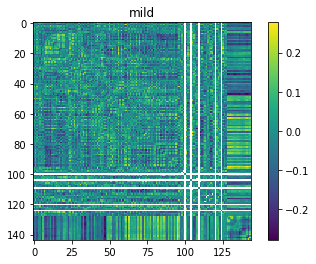

In [30]:
plt.imshow(ciCOH['mild']);
plt.colorbar()
plt.title('mild')
plt.show()

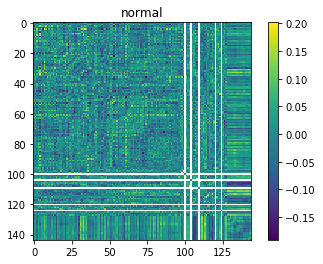

In [29]:
plt.imshow(ciCOH['normal'])
plt.title('normal')
plt.colorbar()
plt.show()